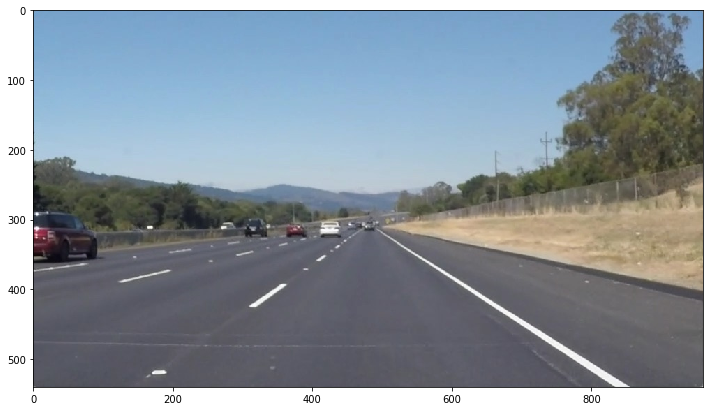

In [1]:
# Import Packages
#importing some useful packages
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize']=[12,8]

imgs = {}
imglist = os.listdir("test_images/")
for name in imglist:
    imgs.update({name.split('.')[0]: cv2.cvtColor(cv2.imread('test_images/'+name), cv2.COLOR_BGR2RGB)})

plt.imshow(imgs["solidWhiteRight"])
plt.show()

In [2]:
def grayscale(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
    return cv2.split(hls)[1]

def color_threshold(img, r, g, b):
    # Mask pixels below the threshold
    color_thresholds =  (img[:,:,0] < r) | \
                        (img[:,:,1] < b) | \
                        (img[:,:,2] < b)
    return color_thresholds

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def parametric_vertices(img, max_height=0.52, upper_edges=(0.48,0.52), lower_edges=(0.05, 0.95)):
    max_height=0.52
    upper_edges=(0.48,0.52)
    lower_edges=(0.05,0.95)
    
    xy=img.shape
    vertices = np.array([[
        (int(upper_edges[0]*xy[1]),int(max_height * xy[0])),
        (int(upper_edges[1]*xy[1]),int(max_height * xy[0])),
        (int(lower_edges[1]*xy[1]),xy[0]),
        (int(lower_edges[0]*xy[1]),xy[0])
    ]])
    return vertices

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha=0.8, beta=1., lamb_da=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, lamb_da)

def get_slope(lines):
    lines = lines.astype(np.float)
    dx = (lines[:,0,0] - lines[:,0,2]) + 1e-16
    dy = (lines[:,0,1] - lines[:,0,3]) + 1e-16
    slope = dy/dx
    # truncate to zero very small segments
    return slope

def line_candidates_by_slope_threshold(lines, thresholds=(0.4,-0.4)):
    slope = get_slope(lines)
    left_mark = np.where(slope < thresholds[1])[0]
    right_mark = np.where(slope > thresholds[0])[0]
#     lines = lines.astype(np.int)
    return left_mark, right_mark

def get_close_values(slope, numstds=1):
    stdev = np.std(slope)
    median = np.median(slope)
    return  np.where(abs(slope-median) < abs(numstds*stdev))

def best_fit_line(line):
    X = line[:,0,0].tolist()
    X.extend(line[:,0,2].tolist())
    Y = line[:,0,1].tolist()
    Y.extend(line[:,0,3].tolist())
    Y = np.array(Y)
    X = np.array(X)
    return np.polyfit(X,Y,1)

def get_poly(img, polynomial):
    xy = img.shape
    X = np.arange(0,xy[0])
    return (X*polynomial[0] + polynomial[1]).astype(np.int)

# Find Line Crossections
def find_xsection(line_1, line_2):
    """
    Lines intersect at y1=y2, hence
    m1 x + C1 = m2 x + C2 =>
    x = (C2-C1) / (m1-m2)
    """
    num = (line_2[1] - line_1[1])
    denom = (line_1[0] - line_2[0])

    x = num/denom if denom != 0 else 0
    y = line_1[0] * x + line_1[1]
    return int(x),int(y)

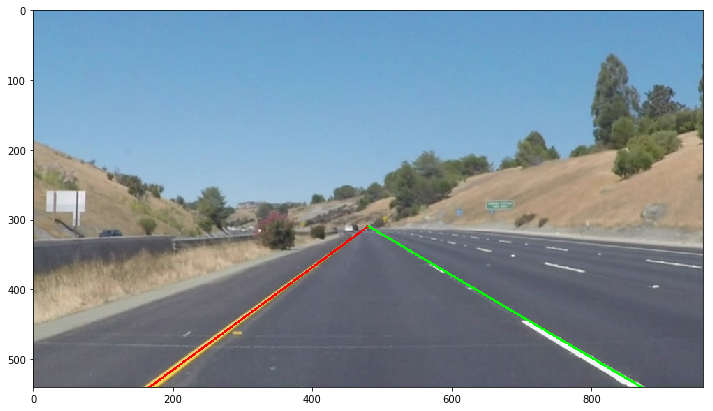

In [3]:
img = imgs['solidWhiteCurve'].copy()

def process_image(img):
    gray = grayscale(img)
    blurred = gaussian_blur(gray, 3)
    ret,thresh = cv2.threshold(blurred,127,255,cv2.THRESH_TOZERO)
    vertices = parametric_vertices(thresh, max_height=0.52, upper_edges=(0.48,0.52), lower_edges=(0.05, 0.95))
    roi = region_of_interest(thresh, vertices=vertices)
    edges = cv2.Canny(roi, 50, 150)
    rho, theta, threshold, min_line_len, max_line_gap = (1, np.pi/180, 60, 5, 1)
    _, lines = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)

    left_lines_indx, right_lines_indx = line_candidates_by_slope_threshold(lines, thresholds=(0.4,-0.4))
    left_slope = get_slope(lines[left_lines_indx])
    right_slope = get_slope(lines[right_lines_indx])

    # get all values close (1 std) to the median
    left_slope_indx = get_close_values(left_slope, numstds=1)
    right_slope_indx = get_close_values(right_slope, numstds=1)

    # extract actual lines
    left_line = lines[left_lines_indx[left_slope_indx]]
    right_line = lines[right_lines_indx[right_slope_indx]]

    # sort them and find their best fit 1st degree polynomial
    left_line_poly = best_fit_line(left_line)
    right_line_poly = best_fit_line(right_line)

    line_cross_section = find_xsection(left_line_poly, right_line_poly)

    left_lane_end_points = [[[0,
                              int(left_line_poly[1]),
                              line_cross_section[0],
                              int(line_cross_section[0] * left_line_poly[0] + left_line_poly[1])
                           ]]]

    right_lane_end_points = [[[line_cross_section[0],
                              line_cross_section[1],
                              img.shape[1],
                              int(img.shape[1] * right_line_poly[0] + right_line_poly[1])
                           ]]]

    # Estimate poly lines
    line_img = draw_lines(img, left_lane_end_points, color=[255,0,0], thickness=2)
    line_img = draw_lines(img, right_lane_end_points, color=[0,255,0], thickness=2)
    return img

# line_img = draw_lines(img, draw_poly(img, right_line_poly), color=[0,255,0], thickness=2)

plt.imshow(process_image(imgs['solidYellowCurve2']))

In [5]:
%timeit process_image(imgs['solidWhiteCurve'])

100 loops, best of 3: 10.3 ms per loop
